In [40]:
# Memory Allocation for using GPU 
import tensorflow as tf 
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import torch
# if installation required(torchvision)
# cmd: conda install -c pytorch torchvision
from torchvision import transforms, models
import cv2
import os


1 Physical GPUs, 1 Logical GPUs


## Download and Load Model
* https://pytorch.org/docs/stable/torchvision/models.html#fully-convolutional-networks 
* https://pytorch.org/docs/stable/torchvision/models.html#deeplabv3

In [2]:
model = models.segmentation.deeplabv3_resnet101(pretrained=True).eval() # Evaluation Mode

Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to C:\Users\user/.cache\torch\hub\checkpoints\resnet101-5d3b4d8f.pth
100%|██████████| 170M/170M [00:16<00:00, 11.2MB/s]
Downloading: "https://download.pytorch.org/models/deeplabv3_resnet101_coco-586e9e4e.pth" to C:\Users\user/.cache\torch\hub\checkpoints\deeplabv3_resnet101_coco-586e9e4e.pth
100%|██████████| 233M/233M [00:22<00:00, 11.0MB/s]


In [59]:
BASE_PATH = os.path.abspath(".")
DATA_PATH = os.path.abspath("..\\..\\00_MLDL\\00_BreadBrother\\08_Semantic_Segmentation")
print(f"{BASE_PATH}\n{DATA_PATH}")


d:\GitHub\semantic_segmentation_clone
d:\00_MLDL\00_BreadBrother\08_Semantic_Segmentation


## Create Color Palette

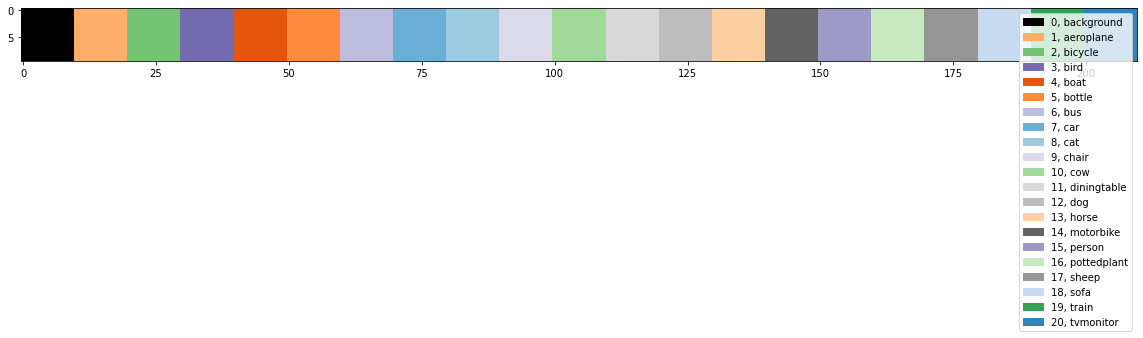

In [55]:
# Coco dataset
labels = ['background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']

cmap = plt.cm.get_cmap('tab20c')
a = cmap(np.arange(cmap.N)) * 255
colors = (cmap(np.arange(cmap.N)) * 255).astype(np.int)[:, :3].tolist() # Shape: (20, 3)
np.random.seed(2020)
np.random.shuffle(colors)
colors.insert(0, [0, 0, 0]) # Background color: black
colors = np.array(colors, dtype=np.uint8) # Shape: (21, 3)

palette_map = np.empty((10, 0, 3), dtype=np.uint8)
legend = []

for i in range(len(colors.tolist())):
    legend.append(mpatches.Patch(color=np.array(colors[i]) / 255., label=f"{i:d}, {labels[i]:s}"))
    c = np.full((10, 10, 3), colors[i], dtype=np.uint8) # 10x10 size color-map 1each
    palette_map = np.concatenate([palette_map, c], axis=1) # link color-map

plt.figure(figsize = (20,2))
plt.legend(handles = legend)
plt.imshow(palette_map)

## Segment Function

In [66]:
def segment(net, img):
    # Image preprocess
    preprocess = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std =[0.229, 0.224, 0.225]
        ),
    ])

    input_tensor = preprocess(img) #(3, height, width)
    input_batch = input_tensor.unsqueeze(0) #(1, 3, height, width) 

    if torch.cuda.is_available():
        input_batch = input_batch.to("cuda")
        model.io("cuda")

    output = model(input_batch)["out"][0] # (21, height, width)

    output_predictions = output.argmax(0).byte().cpu().numpy() # (height, width)

    r = Image.fromarray(output_predictions).resize((img.shape[1], img.shape[0])) # resize(width, height)
    r.putpalette(colors)

    return r, output_predictions

## Result

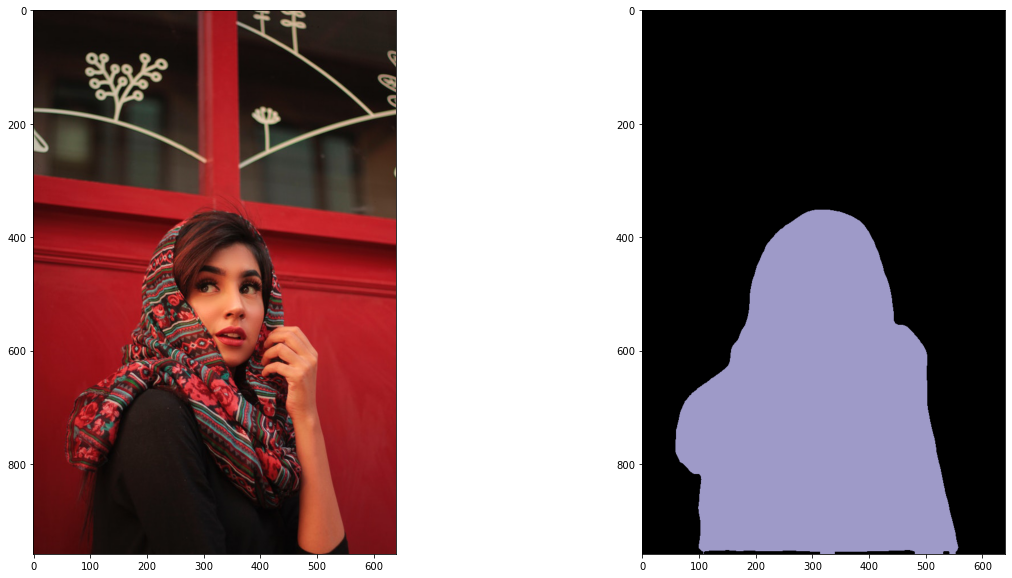

In [69]:
img = np.array(Image.open(os.path.join(DATA_PATH,"imgs\\02.jpg"))) #(959, 640, 3)

fg_h, fg_w, _ = img.shape # 959, 640, 3

segment_map, pred = segment(model, img) # pred:(959, 640)

fig, axes = plt.subplots(1, 2, figsize=(20, 10))
axes[0].imshow(img)
axes[1].imshow(segment_map)

## Load Background Image and Resize
* make same size as foreground
* cv2 Border Type  
![cv2 Border Type](https://github.com/yhhyunn/semantic_segmentation_clone/raw/master/cv2_border.jpg)

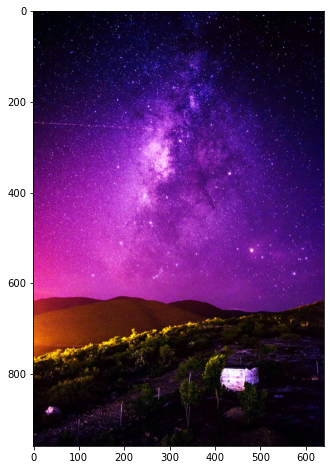

In [104]:
background = np.array(Image.open(os.path.join(DATA_PATH, "imgs\\bg02.jpg")))

bg_h, bg_w, _ = background.shape #(960, 640, 3)

# Fit to foreground width

# fg_w : fg_h ratio 
# 640(bg_w) --> 640(result) = 640(bg_w) * 1(width ratio)
# --> 960(bg_h) --> 960(result) = 960(bg_h) * 1(width ratio)
background = cv2.resize(background, dsize=(fg_w, int( bg_h *( fg_w/ bg_w)))) 
bg_h_resized, bg_w_resized, _ = background.shape # (960, 640, 3)

margin = (bg_h_resized - fg_h) // 2 # margin check

# Process for height
if margin > 0: # resized image height is bigger than foreground image height, cut image
    background = background[margin:-margin, :, :]

else: # resized image height is samller than foreground image height, add padding
    background = cv2.copyMakeBorder(background, top=abs(margin), bottom=abs(margin), left=0, right=0, borderType=cv2.BORDER_REPLICATE)

# Final resize
background = cv2.resize(background, dsize=(fg_w, fg_h))

plt.figure(figsize=(12, 8))
plt.imshow(background)

## Separate Foreground and Background

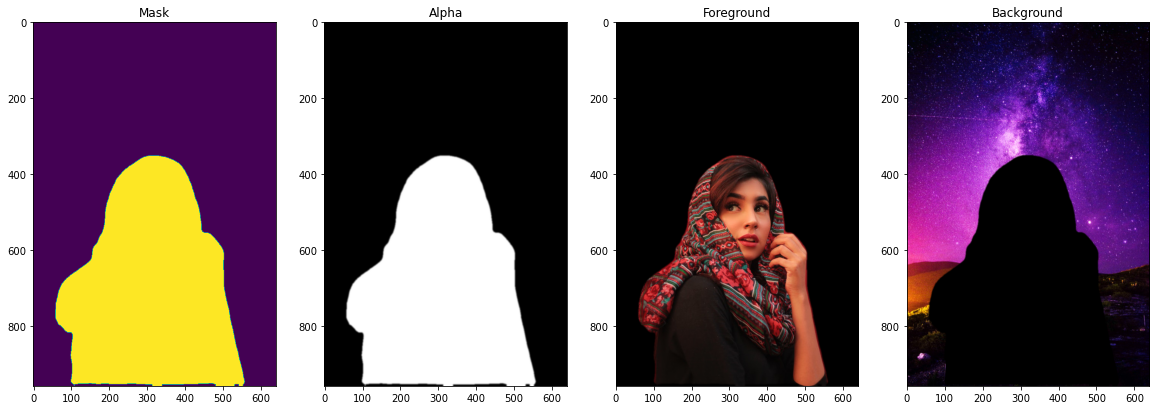

In [107]:
mask = ( pred == 15 ).astype(float) * 255 # 15: person, 1 * 255
th_val, alpha = cv2.threshold(mask, 0, 255, cv2.THRESH_BINARY) # >th: 1 // <th: 0

alpha = cv2.GaussianBlur(alpha, (7,7), 0).astype(float)

alpha = alpha / 255. # (height, width), normalize
alpha = np.repeat(np.expand_dims(alpha, axis=2), 3, axis=2) # (height, width, 3)

foreground = cv2.multiply(alpha, img.astype(float))
background = cv2.multiply(1. - alpha, background.astype(float))

plt.figure(figsize = (20, 15))
plt.subplot(1,4,1)
plt.title("Mask")
plt.imshow(mask)

plt.subplot(1,4,2)
plt.title("Alpha")
plt.imshow(alpha)

plt.subplot(1,4,3)
plt.title("Foreground")
plt.imshow(foreground.astype(np.uint8))

plt.subplot(1,4,4)
plt.title("Background")
plt.imshow(background.astype(np.uint8))

## Result

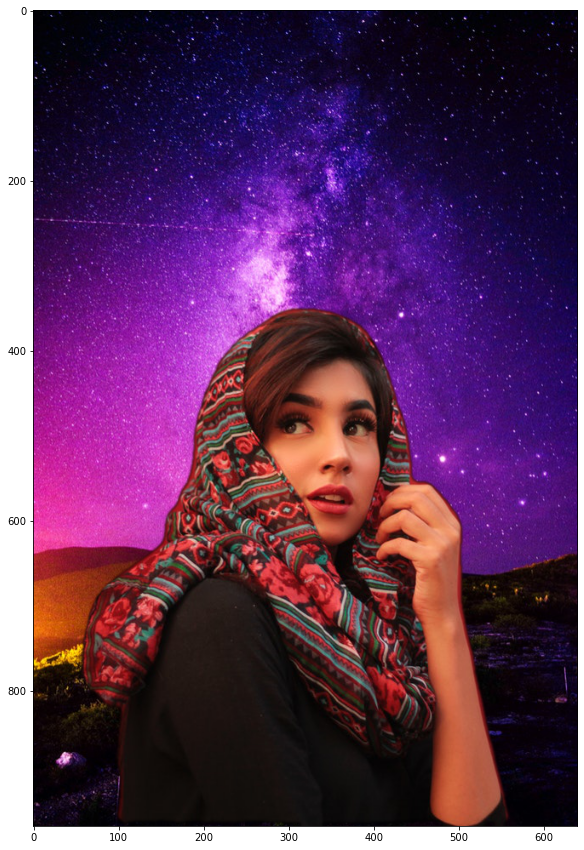

In [118]:
result = cv2.add(foreground, background).astype(np.uint8)

Image.fromarray(result).save(os.path.join(BASE_PATH, "result.jpg"))

plt.figure(figsize = (20, 15))
plt.imshow(result)

## Blur

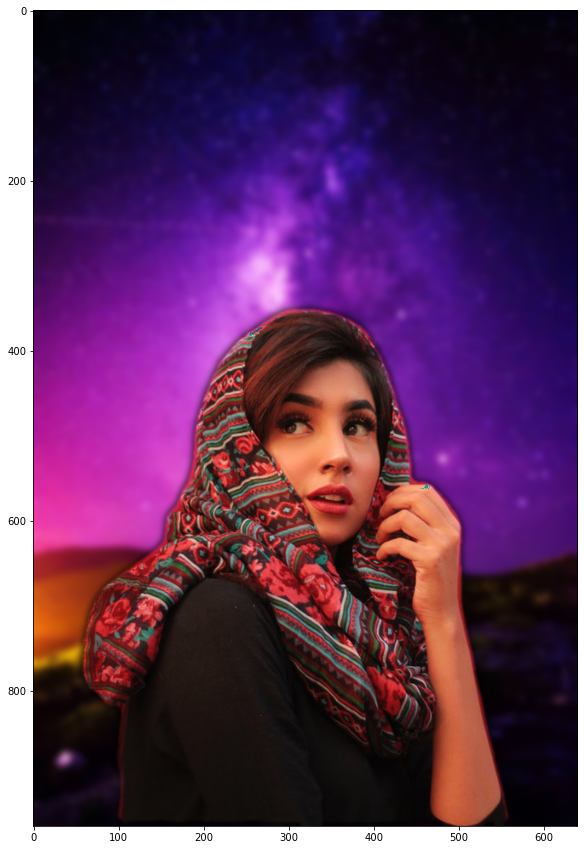

In [173]:
blurred_background = cv2.GaussianBlur(background, (25,25), 0)

blurred_result = cv2.add(foreground, blurred_background).astype(np.uint8)

Image.fromarray(blurred_result).save(os.path.join(BASE_PATH, "result_blurred.jpg"))

plt.figure(figsize=(20,15))
plt.imshow(blurred_result)

## Gray-scale Background

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


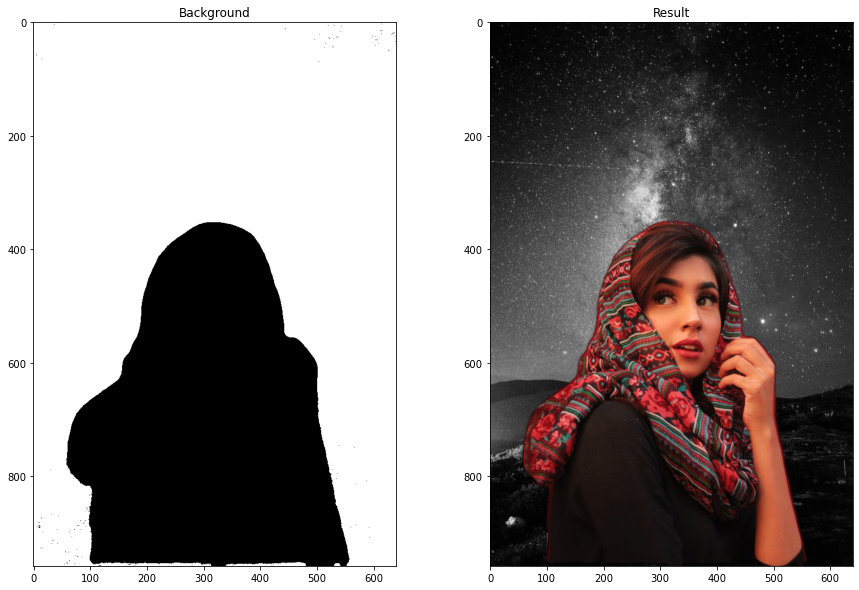

In [134]:
gray_background = cv2.cvtColor(background.astype(np.uint8), cv2.COLOR_BGR2GRAY)
gray_background = cv2.cvtColor(gray_background, cv2.COLOR_GRAY2BGR).astype(float) # 

gray_result = cv2.add(foreground, gray_background).astype(np.uint8)

plt.figure(figsize=(15,10))
plt.subplot(1,2,1)
plt.title("Background")
plt.imshow(gray_background)
plt.subplot(1,2,2)
plt.title("Result")
plt.imshow(gray_result)

## Other Image Segmantation

Target size: (640, 960)


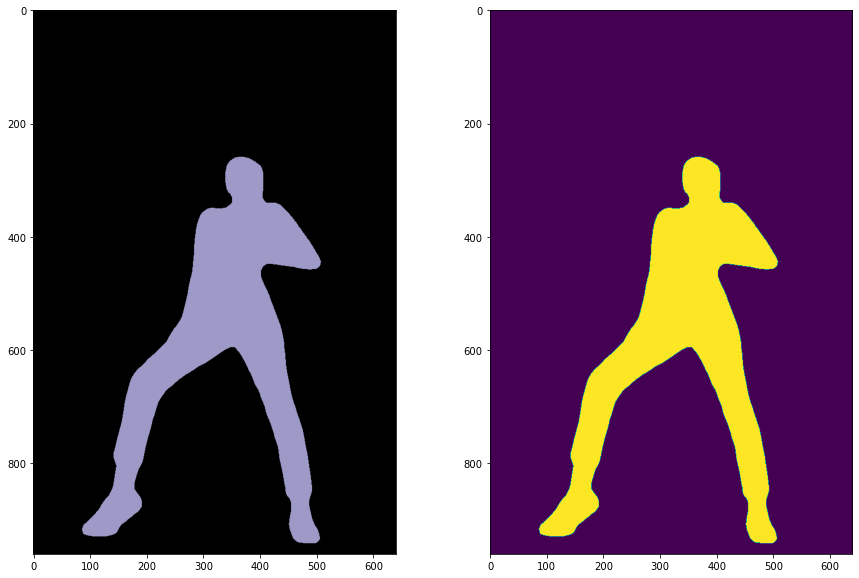

In [165]:
img_other = np.array(Image.open(os.path.join(DATA_PATH,"imgs\\04.jpg"))) #(960, 640, 3)

tg_h, tg_w, _ = img_other.shape

segment_map, pred = segment(model, img_other)

print(f"Target size: ({tg_w}, {tg_h})")

fig, axes = plt.subplots(1, 2, figsize=(15,10))
axes[0].imshow(segment_map)
axes[1].imshow(pred)

## Background

Target size: (640, 960)
Background size: (640, 423)
Background resize: (1452, 960)


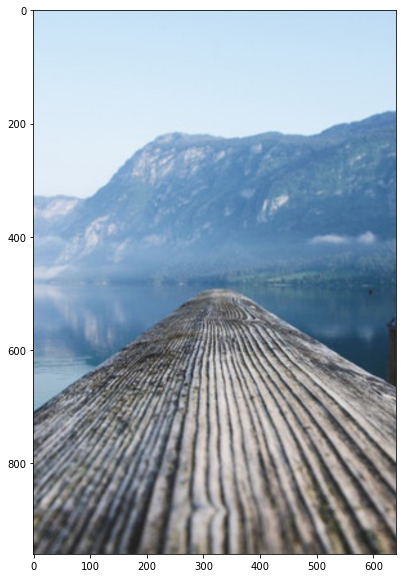

In [169]:
background_other = np.array(Image.open(os.path.join(DATA_PATH,"imgs\\bg01.jpg"))) #(960, 640, 3)

ref_h, ref_w, _ = background_other.shape

background_other_resize = cv2.resize(background_other, dsize=(int(ref_w * (tg_h/ref_h)), tg_h))

ref_h_resize, ref_w_resize, _ = background_other_resize.shape

# 
print(f"Target size: ({tg_w}, {tg_h})")
print(f"Background size: ({ref_w}, {ref_h})")
print(f"Background resize: ({ref_w_resize}, {ref_h_resize})")
#

margin_w = (ref_w_resize - tg_w) // 2

if margin_w > 0:
    background_other_resize = background_other_resize[:, margin_w:-margin_w, :]

else:
    background_other_resize = cv2.copyMakeBorder(background_other_resize, left=abs(margin), right=abs(margin), top=0, bottom=0, borderType=cv2.BORDER_REPLICATE)


background_other_resize = cv2.resize(background_other_resize, dsize=(tg_w, tg_h))

plt.figure(figsize=(15,10))
plt.imshow(background_other_resize)

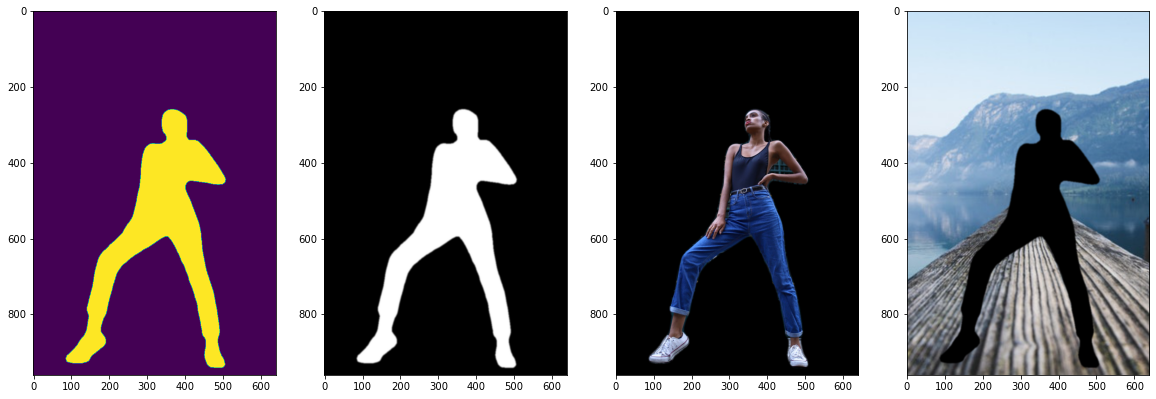

In [172]:
mask_person = (pred==15).astype(float) * 255 # 1 * 255 Expand
th_val, beta = cv2.threshold(mask_person, 0, 255, cv2.THRESH_BINARY)

# Gaussian
beta = cv2.GaussianBlur(beta, (7,7), 0).astype(float)
 
# Normalize
beta = beta / 255.0 # 0 ~ 1 normalize

# make 3D channel
beta = np.repeat(np.expand_dims(beta, axis=2), 3, axis=2)

# Multiplication element-wise
foreground_o = cv2.multiply(beta, img_other.astype(float))
background_o = cv2.multiply(1. - beta, background_other_resize.astype(float))

# Plot
fig, axes = plt.subplots(1,4, figsize=(20, 15))
axes[0].imshow(mask_person) 
axes[1].imshow(beta)
axes[2].imshow(foreground_o.astype(np.uint8))
axes[3].imshow(background_o.astype(np.uint8))

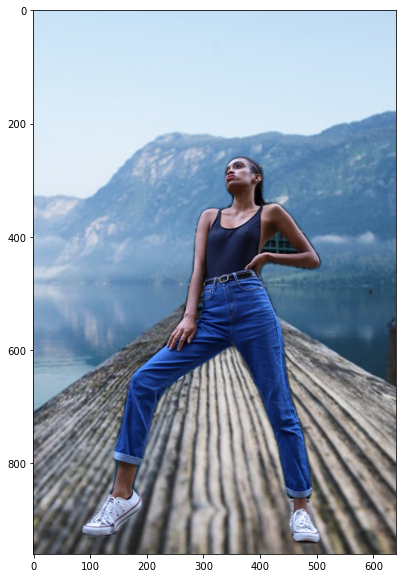

In [174]:
result_o = cv2.add(foreground_o, background_o).astype(np.uint8)

Image.fromarray(result_o).save(os.path.join(BASE_PATH, "result_other.jpg"))

plt.figure(figsize=(15,10))
plt.imshow(result_o)